In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from tempo.data.datasets import finetune_dataset
from tempo.models import NewTempoLinear

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Using device: {device}.')

Using device: cuda.


In [2]:
train_loader_ft = finetune_dataset(name='ASL-big', train=True, batch_size=1)
test_loader_ft = finetune_dataset(train=False, batch_size=1)

weights = torch.load("./model_zoo/baseline.pth")
model = NewTempoLinear(out_features=24, weights=None, freeze_backbone=True)
model.load_state_dict(weights)
model.to(device)

NewTempoLinear(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [3]:
def get_features(reps, layer):
    def hook(model, input, output):
        reps[layer].append(output.data)
    return hook

In [4]:
reps_train = {
    'l1': [],
    'l2': [],
    'l3': [],
    'l4': [],
    'labels': []
}

reps_test = {
    'l1': [],
    'l2': [],
    'l3': [],
    'l4': [],
    'labels': []
}

In [5]:
h1 = model.backbone[4].register_forward_hook(get_features(reps_train, 'l1'))
h2 = model.backbone[5].register_forward_hook(get_features(reps_train, 'l2'))
h3 = model.backbone[6].register_forward_hook(get_features(reps_train, 'l3'))
h4 = model.backbone.register_forward_hook(get_features(reps_train, 'l4'))

In [6]:
# Compute train representations

with torch.no_grad():
    for input, label in train_loader_ft:

        _ = model.backbone(input.to(device)).detach()
        reps_train['labels'].append(label)

In [7]:
reps_train['l1'] = torch.cat(reps_train['l1'], dim=0)
reps_train['l2'] = torch.cat(reps_train['l2'], dim=0)
reps_train['l3'] = torch.cat(reps_train['l3'], dim=0)
reps_train['l4'] = torch.cat(reps_train['l4'], dim=0)

In [8]:
h1.remove()
h2.remove()
h3.remove()
h4.remove()

In [9]:
h1 = model.backbone[4].register_forward_hook(get_features(reps_test, 'l1'))
h2 = model.backbone[5].register_forward_hook(get_features(reps_test, 'l2'))
h3 = model.backbone[6].register_forward_hook(get_features(reps_test, 'l3'))
h4 = model.backbone.register_forward_hook(get_features(reps_test, 'l4'))

In [10]:
# Compute test representations

with torch.no_grad():
    for input, label in test_loader_ft:

        _ = model.backbone(input.to(device)).detach()
        reps_test['labels'].append(label)

In [11]:
reps_test['l1'] = torch.cat(reps_test['l1'], dim=0)
reps_test['l2'] = torch.cat(reps_test['l2'], dim=0)
reps_test['l3'] = torch.cat(reps_test['l3'], dim=0)
reps_test['l4'] = torch.cat(reps_test['l4'], dim=0)

In [12]:
reps_test['l4'].shape

torch.Size([120, 512, 1, 1])

## Test on layer 3 reps 

In [22]:
def test_model(model, test_reps, device):

    all = len(list(test_reps))
    
    model.eval()

    wrongly_classified = 0
    for repr, label in test_reps:
        print('b')

        inputs, labels = repr.flatten(start_dim=0).to(device), label.to(device)

        with torch.no_grad():
            preds = model(inputs).argmax(dim=0)
            print(preds)
            print(labels)
            print('hello')

    model.train()

    return 1.0 - (wrongly_classified / all)

In [23]:
iterations = 3_000

model = nn.Linear(
        in_features = 512*1*1, 
        out_features = 24, 
        bias=True
    ).to(device)

criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.0001)

losses, errors, iters_ = [], [], []
i = 0
every = 1
running_loss = 0.0
b1 = False
while True:
    for repr, label in zip(reps_train['l4'], reps_train['labels']):
        if i % every == 0:
            test_error = test_model(model, zip(reps_test['l4'], reps_test['labels']), device)
            losses.append(running_loss)
            errors.append(test_error)
            iters_.append(i)
            running_loss = 0

            if i == iterations:
                b1=True
                break

        labels = nn.functional.one_hot(label, num_classes=24).float()
        inputs, labels = repr.flatten(start_dim=0).to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        outputs = outputs[None]

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        i += 1

    if i == iterations and b1:
        break
losses, errors, iters_ = np.array(losses), np.array(errors), np.array(iters_)

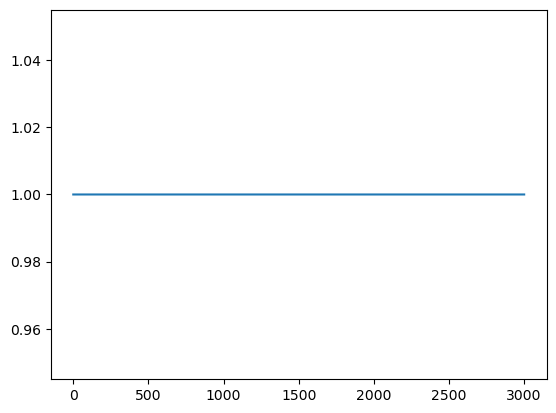

In [15]:
plt.plot(iters_, errors)